# Active Feedback Control for Diabatic Errors

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm

from qec_variables import *

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dia, isherm=True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [2]:
def op_on_qubit(op, i, N=3):
    return tensor([op if k == i else I for k in range(N)])

In [3]:
X = sigmax()
Z = sigmaz()
I = qeye(2)


# Pauli operators on 3 qubits
X1, X2, X3 = [op_on_qubit(X, i) for i in range(3)]
Z1, Z2, Z3 = [op_on_qubit(Z, i) for i in range(3)]

# Stabilizers
S1 = Z1 * Z2
S2 = Z2 * Z3

# Initial state: logical |0_L> = |000>
psi0 = tensor(basis(2,0), basis(2,0), basis(2,0))
rho = ket2dm(psi0)

# Target logical states for fidelity
zero = tensor(basis(2,0), basis(2,0), basis(2,0))
one  = tensor(basis(2,1), basis(2,1), basis(2,1))

state3 = tensor(basis(2,0), basis(2,0), basis(2,1))
state4 = tensor(basis(2,0), basis(2,1), basis(2,0))
state5 = tensor(basis(2,0), basis(2,1), basis(2,1))
state6 = tensor(basis(2,1), basis(2,0), basis(2,0))
state7 = tensor(basis(2,1), basis(2,0), basis(2,1))
state8 = tensor(basis(2,1), basis(2,1), basis(2,0))



In [4]:
# Parameters
gamma_m = 1.0  # Measurement strength
T_max = 500 / gamma_m
dt = 0.1*gamma_m  # Time step for numerical integration
times =  np.arange(0, T_max, dt)
sigma = 50 / gamma_m      # pulse width
omega_max = 0.1

measurement_strength = 1.0
feedback_strength = 5

# Pulses
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max / 2) / sigma) ** 2)
delta_t = lambda t: 4 * omega_max * (t / (T_max / 2) - 1)

# Operators
X, Z, I = sigmax(), sigmaz(), qeye(2)

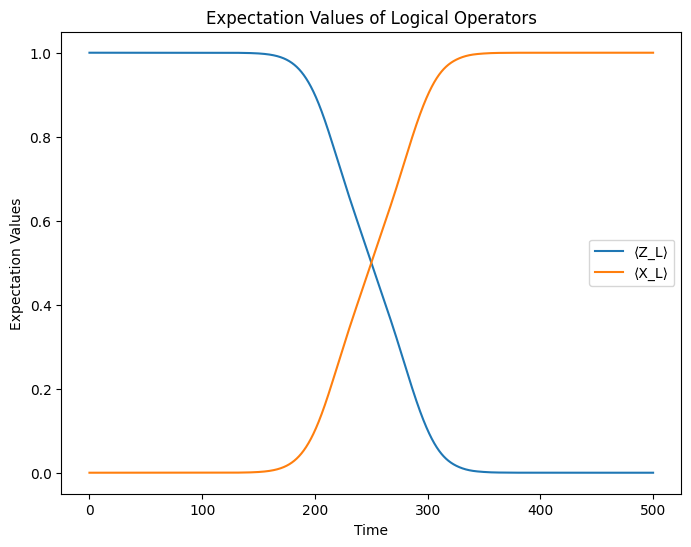

In [5]:
P0 = zero * zero.dag()
P1 = one * one.dag()
H = [[X_L, omega_t], [Z_L, delta_t]]
results = sesolve(H,
    psi0=zero,
    tlist=times,
    e_ops=[P0, P1]
)
# plot fidelities
plt.figure(figsize=(8, 6))
plt.plot(times, np.abs(results.expect[0]), label="⟨Z_L⟩")
plt.plot(times, np.abs(results.expect[1]), label="⟨X_L⟩")
plt.xlabel("Time")
plt.ylabel("Expectation Values")
plt.title("Expectation Values of Logical Operators")
plt.legend()
plt.show()

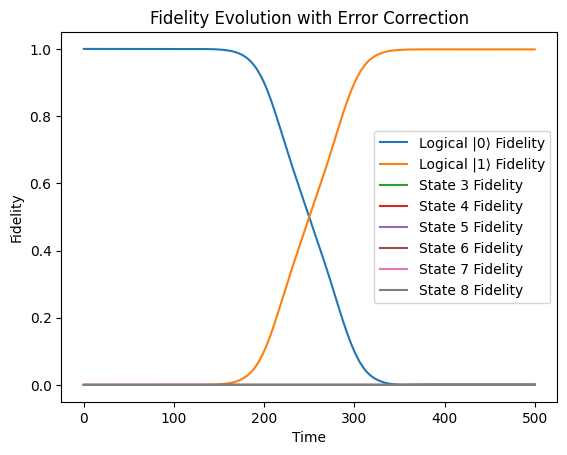

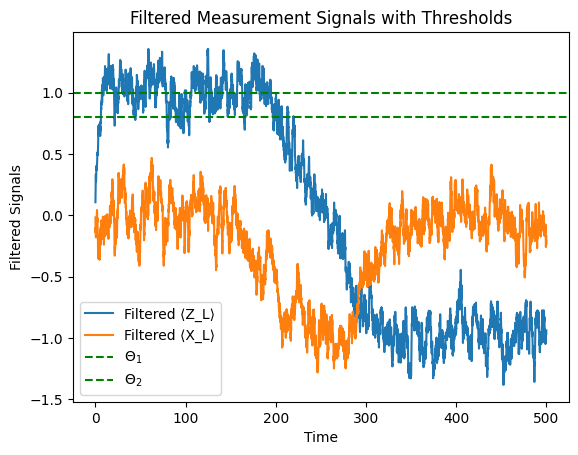

In [6]:
# Initialize filtered measurement signals
I_ZL_bar, I_XL_bar = 0.0, 0.0

# Record fidelity
fidelities_0 = []
fidelities_1 = []
fidelities_2 = []
fidelities_3 = []
fidelities_4 = []
fidelities_5 = []
fidelities_6 = []
fidelities_7 = []
errors = []

I_ZLs = []
I_XLs = []

# Parameters
gamma = 1.25e-9 * gamma_m # bit flip error rate
eta = 1                   # quantum efficiency (1 for ideal detectors)
tau = 2.5 / gamma_m       # measurement time parameter
alpha = dt / tau
theta1 = 1  # threshold for Z_L
theta2 = 0.8  # threshold for X_L

rho = ket2dm(zero)

# Time evolution loop
for t in times:
    # Hamiltonian for rapid adiabatic passage
    H = omega_t(t) * X_L + delta_t(t) * Z_L

    # Effective SME step
    dW_ZL, dW_XL = np.random.normal(scale=np.sqrt(dt), size=2)

    meas_ZL = np.sqrt(2 * gamma_m * eta) * (Z_L * rho + rho * Z_L - 2 * expect(Z_L, rho) * rho)
    meas_XL = np.sqrt(2 * gamma_m * eta) * (X_L * rho + rho * X_L - 2 * expect(X_L, rho) * rho)

    drho = -1j * (H * rho - rho * H)
    # for c in c_ops:
    #     drho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)

    # drho += gamma_m * (Z_L * rho * Z_L - 0.5 * (Z_L**2 * rho + rho * Z_L**2))
    # drho += gamma_m * (X_L * rho * X_L - 0.5 * (X_L**2 * rho + rho * X_L**2))

    # drho += meas_ZL * dW_ZL + meas_XL * dW_XL

    rho = (rho + dt * drho).unit()

    # Measurement currents (with noise)
    I_ZL = expect(Z_L, rho) + dW_ZL / np.sqrt(dt)
    I_XL = expect(X_L, rho) + dW_XL / np.sqrt(dt)

    # Exponential filtering
    I_ZL_bar = (1 - alpha) * I_ZL_bar + alpha * I_ZL
    I_XL_bar = (1 - alpha) * I_XL_bar + alpha * I_XL

    I_ZLs.append(I_ZL_bar)
    I_XLs.append(I_XL_bar)

    # # Double threshold logic
    # if I_ZL_bar < theta1 and I_XL_bar > theta2:
    #     rho = X_L * rho * X_L
    #     I_ZL_bar, I_XL_bar = 1, 1
    #     errors.append(("X_L", t))
    # elif I_ZL_bar > theta2 and I_XL_bar < theta1:
    #     rho = Z_L * rho * Z_L
    #     I_ZL_bar, I_XL_bar = 1, 1
    #     errors.append(("Z_L", t))

    # Record fidelities
    fidelities_0.append(np.abs(zero.dag() * rho * zero))
    fidelities_1.append(np.abs(one.dag() * rho * one))
    fidelities_2.append(np.abs(state3.dag() * rho * state3))
    fidelities_3.append(np.abs(state4.dag() * rho * state4))
    fidelities_4.append(np.abs(state5.dag() * rho * state5))
    fidelities_5.append(np.abs(state6.dag() * rho * state6))
    fidelities_6.append(np.abs(state7.dag() * rho * state7))
    fidelities_7.append(np.abs(state8.dag() * rho * state8))


# Plot results
plt.plot(times, fidelities_0, label='Logical |0⟩ Fidelity')
plt.plot(times, fidelities_1, label='Logical |1⟩ Fidelity')
plt.plot(times, fidelities_2, label='State 3 Fidelity')
plt.plot(times, fidelities_3, label='State 4 Fidelity')
plt.plot(times, fidelities_4, label='State 5 Fidelity')
plt.plot(times, fidelities_5, label='State 6 Fidelity')
plt.plot(times, fidelities_6, label='State 7 Fidelity')
plt.plot(times, fidelities_7, label='State 8 Fidelity')

# for e in errors:
    # plt.axvline(x=e[1], color='red', linestyle='--', label=f"Error: {e[0]}")
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity Evolution with Error Correction")
plt.legend()
plt.show()

plt.plot(times, I_ZLs, label='Filtered ⟨Z_L⟩')
plt.plot(times, I_XLs, label='Filtered ⟨X_L⟩')
plt.axhline(theta1, color='green', linestyle='--', label=r'$\Theta_1$')
plt.axhline(theta2, color='green', linestyle='--', label=r'$\Theta_2$')
# for e in errors:
#     plt.axvline(x=e[1], color='red', linestyle='--', label=f"Error: {e[0]}")
plt.xlabel("Time")
plt.ylabel("Filtered Signals")
plt.title("Filtered Measurement Signals with Thresholds")
plt.legend()
plt.show()

0.07020567769781128 0.9297943223021888


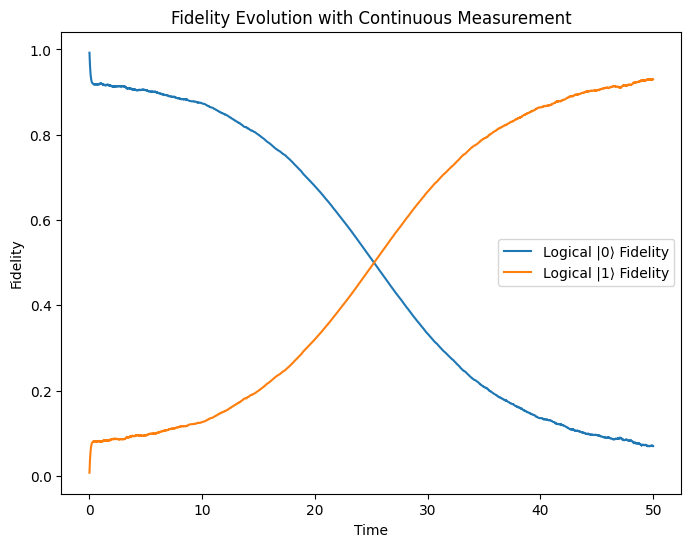

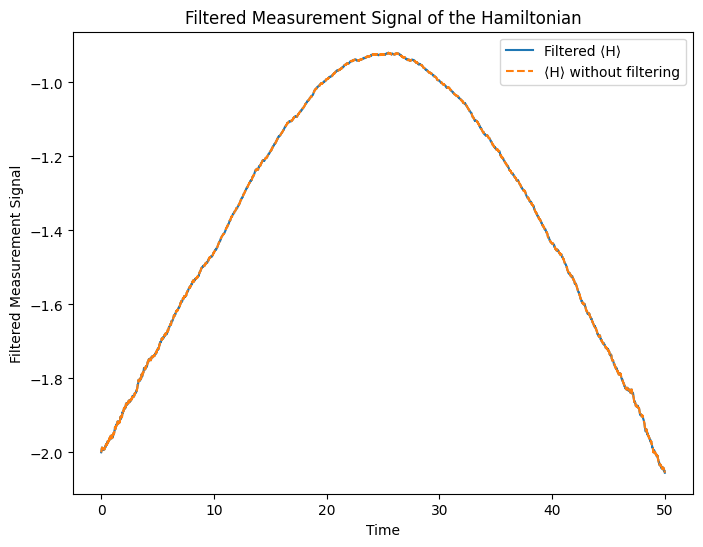

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm


# Parameters
gamma_m = 1  # Measurement strength
T_max = 50 / gamma_m
dt = 0.01 / gamma_m  # Time step
times = np.arange(0, T_max, dt)
sigma = 50 / gamma_m  # Pulse width
omega_max = 1
eta = 1.0  # Quantum efficiency
tau = 2.5 / gamma_m  # Measurement time parameter
alpha = dt / tau

# Logical operators
X = sigmax()
Z = sigmaz()
I = qeye(2)
X1, X2, X3 = [tensor([X if i == k else I for i in range(3)]) for k in range(3)]
Z1, Z2, Z3 = [tensor([Z if i == k else I for i in range(3)]) for k in range(3)]
X_L = X1 * X2 * X3
Z_L = (Z1 + Z2 + Z3) / 3

# Initial state: logical |0_L>
psi0 = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
rho = ket2dm(psi0)

# Pulses
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max / 2) / sigma) ** 2)
delta_t = lambda t: 2 * omega_max * (t / (T_max / 2) - 1)

# Measurement signals
I_H_bar = -2*omega_max
I_Hs = []

# Record fidelities
fidelities_0 = []
fidelities_1 = []

# Target logical states
zero = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
one = tensor(basis(2, 1), basis(2, 1), basis(2, 1))
expects = []

# Time evolution loop
for t in times:
    # Hamiltonian
    H = omega_t(t) * X_L + delta_t(t) * Z_L

    # Continuous measurement of the Hamiltonian
    dW = np.random.normal(scale=np.sqrt(dt))
    meas_H = np.sqrt(2 * gamma_m * eta) * (H * rho + rho * H - 2 * expect(H, rho) * rho)

    # Update density matrix
    drho = -1j * (H * rho - rho * H)
    drho += gamma_m * (H * rho * H - 0.5 * (H**2 * rho + rho * H**2))
    drho += meas_H * dW
    rho = (rho + dt * drho).unit()

    # Measurement current (with noise)
    # I_H = expect(H, rho) + dW / np.sqrt(dt)
    I_H = expect(H, rho)

    # Exponential filtering
    # I_H_bar = (1 - alpha) * I_H_bar + alpha * I_H
    # I_Hs.append(I_H_bar)
    I_Hs.append(I_H)

    # Record fidelities
    fidelities_0.append(np.abs((zero.dag() * rho * zero)))
    fidelities_1.append(np.abs((one.dag() * rho * one)))
    expects.append(expect(H, rho))

print(fidelities_0[-1], fidelities_1[-1])
# Plot results
plt.figure(figsize=(8, 6))
plt.plot(times, fidelities_0, label='Logical |0⟩ Fidelity')
plt.plot(times, fidelities_1, label='Logical |1⟩ Fidelity')
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity Evolution with Continuous Measurement")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(times, I_Hs, label='Filtered ⟨H⟩')
plt.plot(times, expects, label='⟨H⟩ without filtering', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Filtered Measurement Signal")
plt.title("Filtered Measurement Signal of the Hamiltonian")
plt.legend()
plt.show()

0.9572625842787299 0.04273718210632608


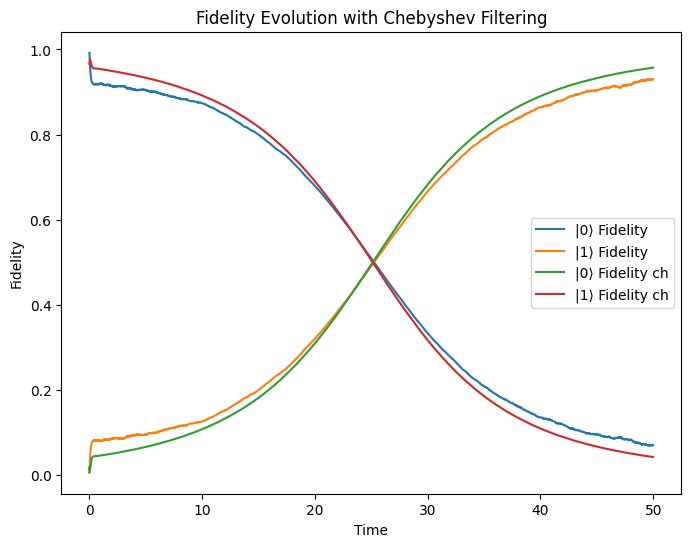

/Users/chenscheim/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/chenscheim/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


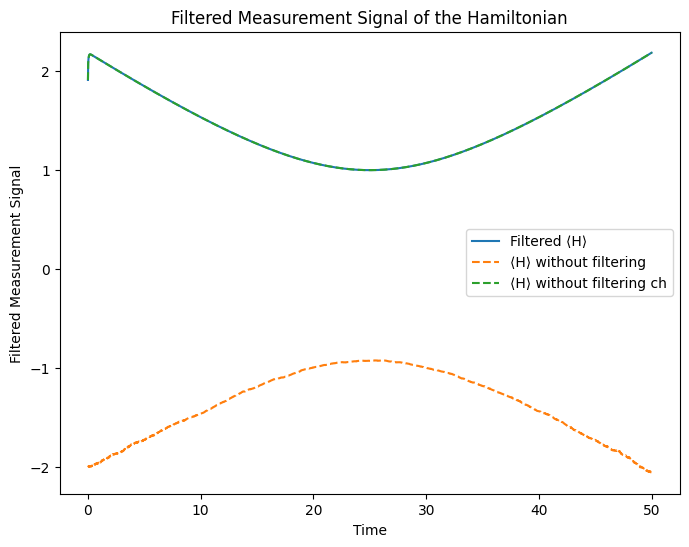

In [8]:
# Chebyshev filtering parameters
cheb_degree = 10
cheb_a = 1

def rescale_H(H):
    evals = H.eigenenergies()
    E_min, E_max = np.min(evals), np.max(evals)
    return (2 * H - (E_max + E_min) * I_L) / (E_max - E_min)

def chebyshev_filter(rho, H_rescaled, degree=cheb_degree, a=cheb_a):
    T0 = rho
    T1 = H_rescaled * rho
    filtered = T0 + 2 * np.exp(-a * 1) * T1

    for n in range(2, degree):
        Tn = 2 * H_rescaled * T1 - T0
        coeff = 2 * np.exp(-a * n)
        filtered += coeff * Tn
        T0, T1 = T1, Tn

    # Normalize trace to 1
    return filtered.unit()


# Measurement signals
I_H_bar = -2 * omega_max
I_Hs = []

# Record fidelities
fidelities_0_ch = []
fidelities_1_ch = []

# Target logical states
zero = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
one = tensor(basis(2, 1), basis(2, 1), basis(2, 1))
expects_ch = []

# Time evolution loop
for i, t in enumerate(times):
    # Hamiltonian
    H = omega_t(t) * X_L + delta_t(t) * Z_L

    # Continuous measurement of the Hamiltonian
    dW = np.random.normal(scale=np.sqrt(dt))
    meas_H = np.sqrt(2 * gamma_m * eta) * (H * rho + rho * H - 2 * expect(H, rho) * rho)

    # Update density matrix
    drho = -1j * (H * rho - rho * H)
    drho += gamma_m * (H * rho * H - 0.5 * (H**2 * rho + rho * H**2))
    drho += meas_H * dW
    rho = (rho + dt * drho).unit()

    # Apply Chebyshev filtering every few steps
    if i % 1 == 0:  # Apply filtering every 10 steps
        H_rescaled = rescale_H(H)
        rho = chebyshev_filter(rho, H_rescaled)

    # Measurement current (with noise)
    I_H = expect(H, rho)

    # Exponential filtering
    # I_H_bar = (1 - alpha) * I_H_bar + alpha * I_H
    # I_Hs.append(I_H_bar)
    I_Hs.append(I_H)

    # Record fidelities
    fidelities_0_ch.append(np.abs((zero.dag() * rho * zero)))
    fidelities_1_ch.append(np.abs((one.dag() * rho * one)))
    expects_ch.append(expect(H, rho))

print(fidelities_0_ch[-1], fidelities_1_ch[-1])

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(times, fidelities_0, label='|0⟩ Fidelity')
plt.plot(times, fidelities_1, label='|1⟩ Fidelity')
plt.plot(times, fidelities_0_ch, label='|0⟩ Fidelity ch')
plt.plot(times, fidelities_1_ch, label='|1⟩ Fidelity ch')
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity Evolution with Chebyshev Filtering")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(times, I_Hs, label='Filtered ⟨H⟩')
plt.plot(times, expects, label='⟨H⟩ without filtering', linestyle='--')
plt.plot(times, expects_ch, label='⟨H⟩ without filtering ch', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Filtered Measurement Signal")
plt.title("Filtered Measurement Signal of the Hamiltonian")
plt.legend()
plt.show()

Chebyshev Degree: 100%|██████████| 2/2 [00:08<00:00,  4.07s/it]

Best parameters: cheb_degree = 1, cheb_a = 0.01
Best fidelity: 0.9297943223021888


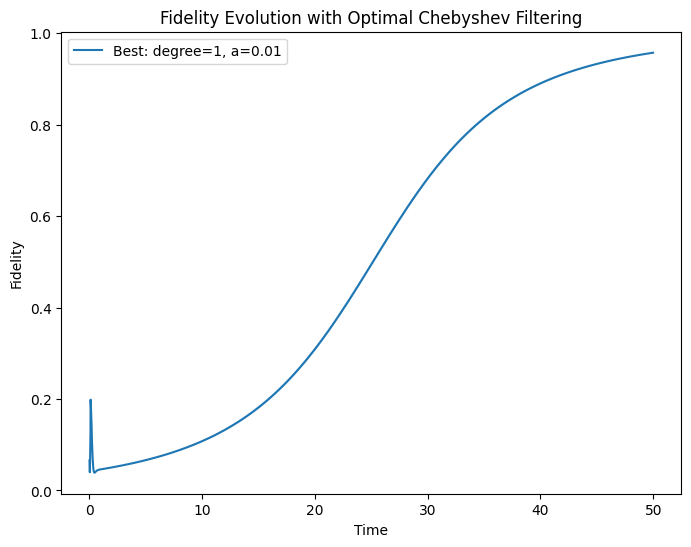

In [9]:
# Parameter ranges
cheb_degrees = [1, 10]
cheb_as = [0.01, 0.1]

# Store results
results = {}

# Loop over parameter combinations
for degree in tqdm(cheb_degrees, "Chebyshev Degree"):
    for a in tqdm(cheb_as, "Chebyshev Amplitude"):
        rho = ket2dm(psi0)
        fidelities_0 = []

        for i, t in enumerate(times):
            # Hamiltonian
            H = omega_t(t) * X_L + delta_t(t) * Z_L

            # Continuous measurement of the Hamiltonian
            dW = np.random.normal(scale=np.sqrt(dt))
            meas_H = np.sqrt(2 * gamma_m * eta) * (H * rho + rho * H - 2 * expect(H, rho) * rho)

            # Update density matrix
            drho = -1j * (H * rho - rho * H)
            drho += gamma_m * (H * rho * H - 0.5 * (H**2 * rho + rho * H**2))
            drho += meas_H * dW
            rho = (rho + dt * drho).unit()

            # Apply Chebyshev filtering every few steps
            if i % 10 == 0:
                H_rescaled = rescale_H(H)
                rho = chebyshev_filter(rho, H_rescaled, degree, a)

            # Record fidelity
            fidelities_0.append(np.abs((zero.dag() * rho * zero)))

        # Store final fidelity
        results[(degree, a)] = fidelities_1[-1]

# Find the best parameters
best_params = max(results, key=results.get)
best_fidelity = results[best_params]

print(f"Best parameters: cheb_degree = {best_params[0]}, cheb_a = {best_params[1]}")
print(f"Best fidelity: {best_fidelity}")

# Plot results for the best parameters
plt.figure(figsize=(8, 6))
plt.plot(times, fidelities_0, label=f"Best: degree={best_params[0]}, a={best_params[1]}")
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity Evolution with Optimal Chebyshev Filtering")
plt.legend()
plt.show()

# Measurement the Hamiltonain

In [ ]:
# Parameters
gamma_m = 50  # Measurement strength
T_max = 500 / gamma_m
dt = 0.01 / gamma_m  # Time step
times = np.arange(0, T_max, dt)
omega_max = 5
eta = 1.0  # Quantum efficiency
tau = 2.5 / gamma_m  # Measurement time parameter
alpha = dt / tau

# Logical operators
X = sigmax()
Z = sigmaz()
I = qeye(2)
X1, X2, X3 = [tensor([X if i == k else I for i in range(3)]) for k in range(3)]
Z1, Z2, Z3 = [tensor([Z if i == k else I for i in range(3)]) for k in range(3)]
X_L = X1 * X2 * X3
Z_L = (Z1 + Z2 + Z3) / 3

# Initial state: logical |0_L>
psi0 = tensor(basis(2, 0), basis(2, 0), basis(2, 0))

plt.figure(figsize=(8, 6))
for s in range(5, 50, 5):  # Start from 5 to avoid division by zero
    print(f"s = {s}")
    sigma = s / gamma_m  # Adjust sigma for pulse width
    rho = ket2dm(psi0)

    # Pulses
    omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max / 2) / sigma) ** 2)
    delta_t = lambda t: 2 * omega_max * (t / (T_max / 2) - 1)

    # Measurement signals
    I_H_bar = -2 * omega_max
    I_Hs = []

    # Record fidelities
    fidelities_0 = []
    fidelities_1 = []

    # Target logical states
    zero = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
    one = tensor(basis(2, 1), basis(2, 1), basis(2, 1))

    # Time evolution loop
    for t in times:
        # Hamiltonian
        H = omega_t(t) * X_L + delta_t(t) * Z_L

        # Continuous measurement of the Hamiltonian
        dW = np.random.normal(scale=np.sqrt(dt))
        meas_H = np.sqrt(2 * gamma_m * eta) * (H * rho + rho * H - 2 * expect(H, rho) * rho)

        # Update density matrix
        drho = -1j * (H * rho - rho * H)
        drho += gamma_m * (H * rho * H - 0.5 * (H**2 * rho + rho * H**2))
        drho += meas_H * dW
        rho = (rho + dt * drho).unit()

        # Measurement current (with noise)
        I_H = expect(H, rho)

        # Exponential filtering
        I_H_bar = (1 - alpha) * I_H_bar + alpha * I_H
        I_Hs.append(I_H_bar)

        # Record fidelities
        fidelities_0.append(np.abs((zero.dag() * rho * zero)))
        fidelities_1.append(np.abs((one.dag() * rho * one)))

    print(f"Final fidelities: |0⟩ = {fidelities_0[-1]}, |1⟩ = {fidelities_1[-1]}")
    plt.plot(times, I_Hs, label=f"s = {s}")

plt.xlabel("Time")
plt.ylabel("Filtered Measurement Signal")
plt.title("Filtered Measurement Signal of the Hamiltonian as function of different detunings")
plt.legend()
plt.show()

s = 5
Final fidelities: |0⟩ = 0.20172038907674167, |1⟩ = 0.7982796109232582
s = 10
Final fidelities: |0⟩ = 0.0420193748843573, |1⟩ = 0.957980625115643
s = 15
Final fidelities: |0⟩ = 0.011744170439508747, |1⟩ = 0.9882558295604914
s = 20


run for omega:   0%|          | 0/5 [00:00<?, ?it/s]

omega_max = 0.1


run for omega:  20%|██        | 1/5 [00:04<00:18,  4.73s/it]

0.5462165251400658 0.45378347485993437
omega_max = 0.3


run for omega:  40%|████      | 2/5 [00:09<00:14,  4.72s/it]

0.1766650418969464 0.8233349581030539
omega_max = 0.5


run for omega:  60%|██████    | 3/5 [00:14<00:09,  4.70s/it]

0.07423296235854994 0.9257670376414504
omega_max = 0.7


run for omega:  80%|████████  | 4/5 [00:18<00:04,  4.68s/it]

0.03978275917826116 0.9602172408217389
omega_max = 1


run for omega: 100%|██████████| 5/5 [00:23<00:00,  4.69s/it]

0.01998297121923843 0.9800170287807612


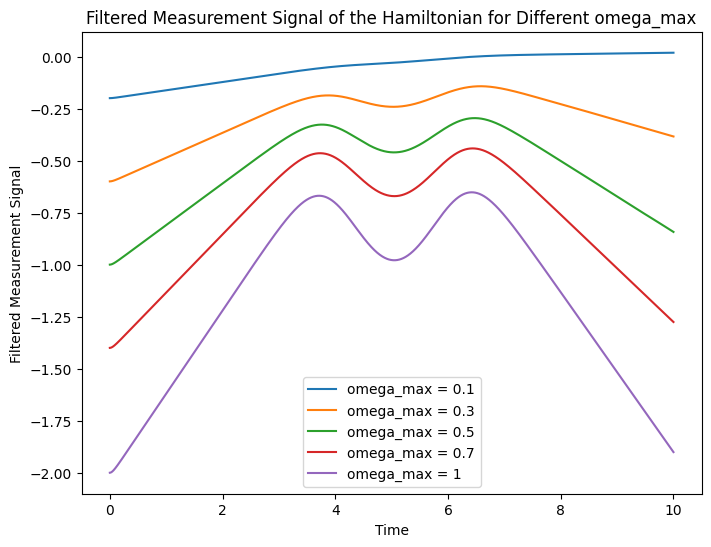

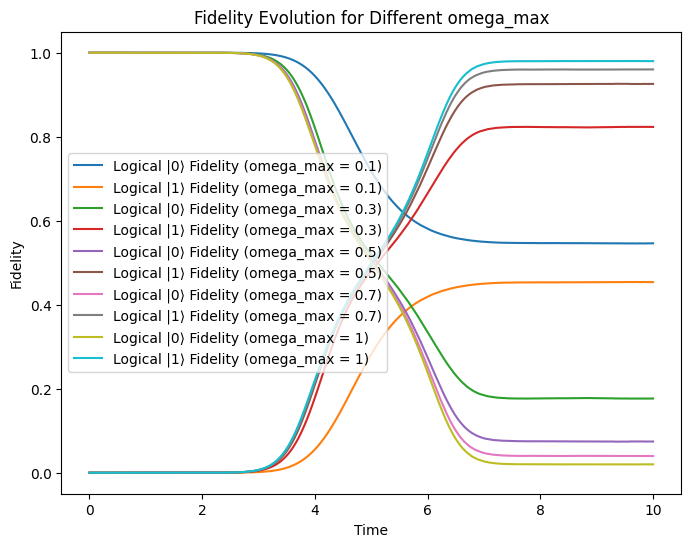

In [ ]:
# Parameters
gamma_m = 50  # Measurement strength
T_max = 500 / gamma_m
dt = 0.01 / gamma_m  # Time step
times = np.arange(0, T_max, dt)
eta = 1.0  # Quantum efficiency
tau = 2.5 / gamma_m  # Measurement time parameter
alpha = dt / tau

# Logical operators
X = sigmax()
Z = sigmaz()
I = qeye(2)
X1, X2, X3 = [tensor([X if i == k else I for i in range(3)]) for k in range(3)]
Z1, Z2, Z3 = [tensor([Z if i == k else I for i in range(3)]) for k in range(3)]
X_L = X1 * X2 * X3
Z_L = (Z1 + Z2 + Z3) / 3

# Initial state: logical |0_L>
psi0 = tensor(basis(2, 0), basis(2, 0), basis(2, 0))

# Target logical states
zero = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
one = tensor(basis(2, 1), basis(2, 1), basis(2, 1))

plt.figure(figsize=(8, 6))
fidelity_results = {}

for omega_max in tqdm([0.1, 0.3, 0.5, 0.7, 1], desc="run for omega: "):  # Different values of omega_max
    sigma = 50 / gamma_m  # Fixed pulse width
    rho = ket2dm(psi0)

    # Pulses
    omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max / 2) / sigma) ** 2)
    delta_t = lambda t: 2 * omega_max * (t / (T_max / 2) - 1)

    # Measurement signals
    I_H_bar = -2 * omega_max
    I_Hs = []
    fidelities_0 = []
    fidelities_1 = []

    # Time evolution loop
    for t in times:
        # Hamiltonian
        H = omega_t(t) * X_L + delta_t(t) * Z_L

        # Continuous measurement of the Hamiltonian
        dW = np.random.normal(scale=np.sqrt(dt))
        meas_H = np.sqrt(2 * gamma_m * eta) * (H * rho + rho * H - 2 * expect(H, rho) * rho)

        # Update density matrix
        drho = -1j * (H * rho - rho * H)
        drho += gamma_m * (H * rho * H - 0.5 * (H**2 * rho + rho * H**2))
        drho += meas_H * dW
        rho = (rho + dt * drho).unit()

        # Measurement current (with noise)
        I_H = expect(H, rho)

        # Exponential filtering
        I_H_bar = (1 - alpha) * I_H_bar + alpha * I_H
        I_Hs.append(I_H_bar)

        # Record fidelities
        fidelities_0.append(np.abs((zero.dag() * rho * zero)))
        fidelities_1.append(np.abs((one.dag() * rho * one)))

    fidelity_results[omega_max] = (fidelities_0, fidelities_1)
    plt.plot(times, I_Hs, label=f"omega_max = {omega_max}")
    print(fidelities_0[-1], fidelities_1[-1])

plt.xlabel("Time")
plt.ylabel("Filtered Measurement Signal")
plt.title("Filtered Measurement Signal of the Hamiltonian for Different omega_max")
plt.legend()
plt.show()

# Plot fidelities
plt.figure(figsize=(8, 6))
for omega_max, (fidelities_0, fidelities_1) in fidelity_results.items():
    plt.plot(times, fidelities_0, label=f"Logical |0⟩ Fidelity (omega_max = {omega_max})")
    plt.plot(times, fidelities_1, label=f"Logical |1⟩ Fidelity (omega_max = {omega_max})")


plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity Evolution for Different omega_max")
plt.legend()
plt.show()

# Chebyshev polynomial filtering

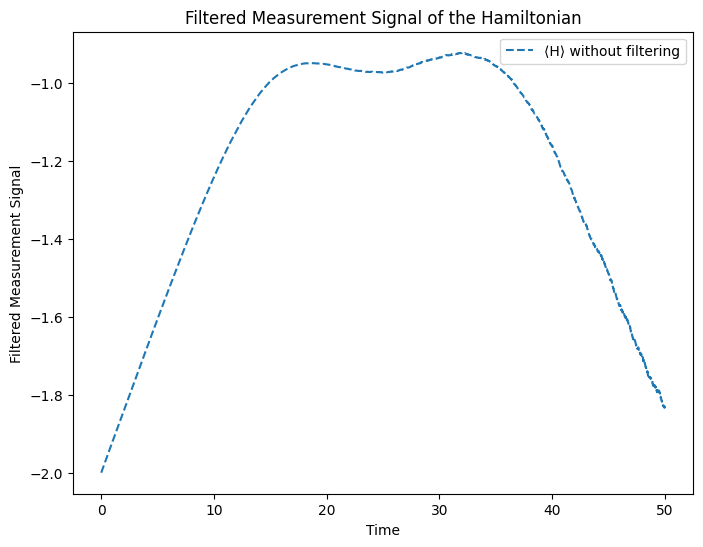

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm

# Parameters
gamma_m = 1  # Measurement strength
T_max = 50 / gamma_m
dt = 0.01 / gamma_m  # Time step
times = np.arange(0, T_max, dt)
sigma = 10 / gamma_m  # Pulse width
omega_max = 1
eta = 1.0  # Quantum efficiency
tau = 2.5 / gamma_m  # Measurement time parameter
alpha = dt / tau

# Logical operators
X = sigmax()
Z = sigmaz()
I = qeye(2)
X1, X2, X3 = [tensor([X if i == k else I for i in range(3)]) for k in range(3)]
Z1, Z2, Z3 = [tensor([Z if i == k else I for i in range(3)]) for k in range(3)]
X_L = X1 * X2 * X3
Z_L = (Z1 + Z2 + Z3) / 3
I_L = tensor([I for _ in range(3)])  # Identity operator on 3 qubits

# Initial state: logical |0_L>
psi0 = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
rho = ket2dm(psi0)

# Pulses
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max / 2) / sigma) ** 2)
delta_t = lambda t: 2 * omega_max * (t / (T_max / 2) - 1)

# Chebyshev filtering parameters
cheb_degree = 1
cheb_a = 0.01

def rescale_H(H):
    evals = H.eigenenergies()
    E_min, E_max = np.min(evals), np.max(evals)
    return (2 * H - (E_max + E_min) * I_L) / (E_max - E_min)

def chebyshev_filter(rho, H_rescaled, degree=50, a=30):
    """
    Applies Chebyshev polynomial spectral filtering to project rho onto
    the low-energy spectrum of H_rescaled.

    Parameters:
        rho        : Qobj density matrix to filter
        H_rescaled: Rescaled Hamiltonian with spectrum in [-1, 1]
        degree     : Number of Chebyshev terms
        a          : Filter sharpness (higher = sharper)

    Returns:
        Qobj filtered density matrix
    """
    T0 = rho
    T1 = H_rescaled * rho
    filtered = np.exp(-a * 0) * T0 + 2 * np.exp(-a * 1) * T1

    for n in range(2, degree):
        Tn = 2 * H_rescaled * T1 - T0
        coeff = 2 * np.exp(-a * n)
        filtered += coeff * Tn
        T0, T1 = T1, Tn

    # Normalize trace to 1
    return filtered.unit()


# Measurement signals
I_H_bar = -2 * omega_max
I_H_bar_one = 2 * omega_max
I_Hs = []
I_H_ones = []

# Record fidelities
fidelities_0 = []
fidelities_1 = []

# Target logical states
zero = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
one = tensor(basis(2, 1), basis(2, 1), basis(2, 1))
expects = []

# Time evolution loop
for i, t in enumerate(times):
    # Hamiltonian
    H = omega_t(t) * X_L + delta_t(t) * Z_L

    # Continuous measurement of the Hamiltonian
    dW = np.random.normal(scale=np.sqrt(dt))
    meas_H = np.sqrt(2 * gamma_m * eta) * (H * rho + rho * H - 2 * expect(H, rho) * rho)

    # Update density matrix
    drho = -1j * (H * rho - rho * H)
    drho += gamma_m * (H * rho * H - 0.5 * (H**2 * rho + rho * H**2))
    drho += meas_H * dW
    rho = (rho + dt * drho).unit()

    # Measurement current (with noise)
    I_H = expect(H, rho)
    # Exponential filtering
    expects.append(I_H)

plt.figure(figsize=(8, 6))
plt.plot(times, expects, label='⟨H⟩ without filtering', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Filtered Measurement Signal")
plt.title("Filtered Measurement Signal of the Hamiltonian")
plt.legend()
plt.show()

0.017279710680904267 0.9827202893190956


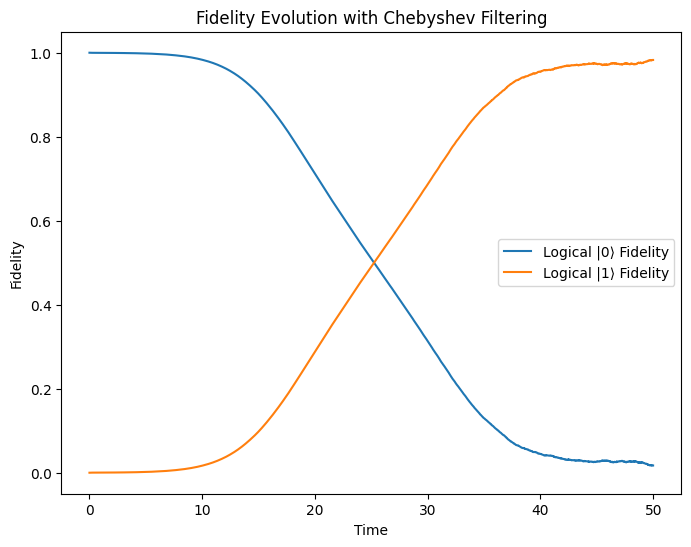

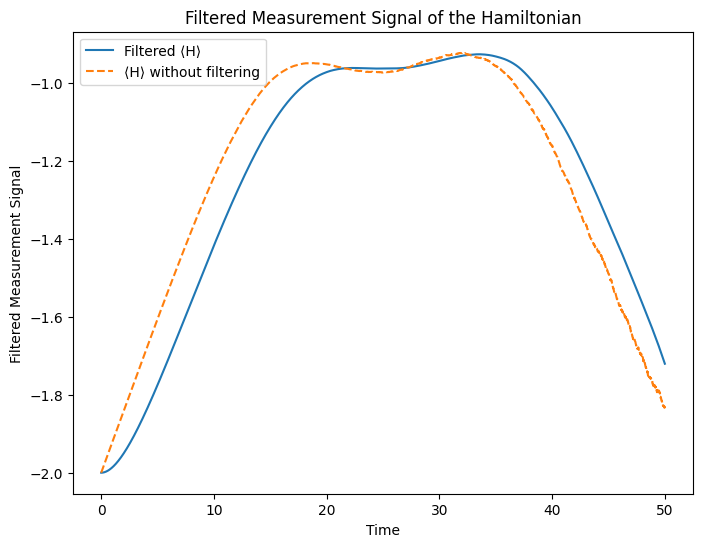

In [ ]:
rho = ket2dm(psi0)

# Chebyshev filtering parameters
cheb_degree = 1
cheb_a = 0.01

def rescale_H(H):
    evals = H.eigenenergies()
    E_min, E_max = np.min(evals), np.max(evals)
    return (2 * H - (E_max + E_min) * I_L) / (E_max - E_min)

def chebyshev_filter(rho, H_rescaled, degree=50, a=30):
    """
    Applies Chebyshev polynomial spectral filtering to project rho onto
    the low-energy spectrum of H_rescaled.

    Parameters:
        rho        : Qobj density matrix to filter
        H_rescaled: Rescaled Hamiltonian with spectrum in [-1, 1]
        degree     : Number of Chebyshev terms
        a          : Filter sharpness (higher = sharper)

    Returns:
        Qobj filtered density matrix
    """
    T0 = rho
    T1 = H_rescaled * rho
    filtered = np.exp(-a * 0) * T0 + 2 * np.exp(-a * 1) * T1

    for n in range(2, degree):
        Tn = 2 * H_rescaled * T1 - T0
        coeff = 2 * np.exp(-a * n)
        filtered += coeff * Tn
        T0, T1 = T1, Tn

    # Normalize trace to 1
    return filtered.unit()


# Measurement signals
I_H_bar = -2 * omega_max
I_Hs = []

# Record fidelities
fidelities_0 = []
fidelities_1 = []

# Target logical states
zero = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
one = tensor(basis(2, 1), basis(2, 1), basis(2, 1))

# Time evolution loop
for i, t in enumerate(times):
    # Hamiltonian
    H = omega_t(t) * X_L + delta_t(t) * Z_L

    # Continuous measurement of the Hamiltonian
    dW = np.random.normal(scale=np.sqrt(dt))
    meas_H = np.sqrt(2 * gamma_m * eta) * (H * rho + rho * H - 2 * expect(H, rho) * rho)

    # Update density matrix
    drho = -1j * (H * rho - rho * H)
    drho += gamma_m * (H * rho * H - 0.5 * (H**2 * rho + rho * H**2))
    drho += meas_H * dW
    rho = (rho + dt * drho).unit()

    # Apply Chebyshev filtering every few steps
    if i % 1 == 0:  # Apply filtering every 10 steps
        H_rescaled = rescale_H(H)
        rho = chebyshev_filter(rho, H_rescaled)

    # Measurement current (with noise)
    I_H = expect(H, rho)
    I_H_one = expect(H, one)

    # Exponential filtering
    I_H_bar = (1 - alpha) * I_H_bar + alpha * I_H
    I_Hs.append(I_H_bar)

    # Record fidelities
    fidelities_0.append(np.abs((zero.dag() * rho * zero)))
    fidelities_1.append(np.abs((one.dag() * rho * one)))

print(fidelities_0[-1], fidelities_1[-1])

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(times, fidelities_0, label='Logical |0⟩ Fidelity')
plt.plot(times, fidelities_1, label='Logical |1⟩ Fidelity')
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity Evolution with Chebyshev Filtering")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(times, I_Hs, label='Filtered ⟨H⟩')
plt.plot(times, expects, label='⟨H⟩ without filtering', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Filtered Measurement Signal")
plt.title("Filtered Measurement Signal of the Hamiltonian")
plt.legend()
plt.show()